## Read time series data and split

In [1]:
import pandas as pd
import numpy as np
import jax.numpy as jnp
import discretize_func as discretize
import tokenizer_func as tokenizer
import pickle

In [2]:
# Read
df = pd.read_parquet("dehli.parquet")

# Fill nans with nearest
df = df.ffill()

# Downsample from 5-min resolution to hourly
#df = df.resample("h").mean()

# Downsample from 5-min resolution to quarterly
df = df.resample("15min").mean()

# Change to numeric index (remove datetime)
df = df.reset_index(drop=True)

# Fill nans with nearest
df = df.ffill()

# Columns of interest
cols = ['Power demand', 'temp', 'dwpt', 'rhum', 'wdir', 'wspd', 'pres']
df = df[cols]

# Split in train/test
split_idx = int(len(df) * 0.8)
X = df.iloc[:split_idx].copy()
Y = df.iloc[split_idx:].copy()

## Pre-processing

* Normalize
* Delta tokens by derivation
* Discretize each column

Current setup:
* delta tokens
* n_bins = 256
* quantile-based bins (centered at 0)

In [3]:
# Z-norm standardisation
#X['Power demand'] = np.log1p(X['Power demand'])
mu = X.mean(axis=0)
sigma = X.std(axis=0) + 1e-8

X_normalized = (X-mu)/sigma
X_normalized = X_normalized.diff().dropna()
X_nv = X_normalized.values.astype(np.float32)   # (N, D)

In [4]:
# fit bins
n_bins=256
edges, mids = discretize.fit_quantile_bins(X_nv, n_bins=n_bins)
#edges, mids = discretize.fit_equal_width_bins(X_nv, n_bins=n_bins)

# encode
X_tok = discretize.encode_quantile(jnp.asarray(X_nv), edges)
#X_tok = discretize.encode_equal_width(jnp.asarray(X_nv), edges)

# decode
X_rec = discretize.decode_quantile(X_tok, mids)
#X_rec = discretize.decode_equal_width(X_tok, mids)


W1219 15:17:23.480452  150557 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1219 15:17:23.483775  150469 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


In [5]:
X

,Power demand,temp,dwpt,rhum,wdir,wspd,pres
0,1999.076667,8.0,6.9,93.0,0.0,0.0,1017.0
1,1952.006667,8.0,6.9,93.0,0.0,0.0,1017.0
2,1882.133333,8.0,6.9,93.0,0.0,0.0,1017.0
3,1822.866667,8.0,6.9,93.0,0.0,0.0,1017.0
4,1779.133333,8.0,6.9,93.0,0.0,0.0,1017.0
...,...,...,...,...,...,...,...
110664,3506.576667,21.0,3.2,31.0,290.0,9.4,1017.0
110665,3504.670000,21.0,3.2,31.0,290.0,9.4,1017.0
110666,3478.290000,21.0,3.2,31.0,290.0,9.4,1017.0
110667,3443.300000,21.0,3.2,31.0,290.0,9.4,1017.0


In [6]:
X_reconstructed = (pd.DataFrame(X_rec, columns=X_normalized.columns) * sigma) + mu
X_reconstructed

,Power demand,temp,dwpt,rhum,wdir,wspd,pres
0,3778.370186,24.73081,15.948551,65.132146,162.562985,8.385113,1009.502607
1,3755.472343,24.73081,15.948551,65.132146,162.562985,8.385113,1009.502607
2,3766.096887,24.73081,15.948551,65.132146,162.562985,8.385113,1009.502607
3,3781.719295,24.73081,15.948551,65.132146,162.562985,8.385113,1009.502607
4,3785.027223,24.73081,15.948551,65.132146,162.562985,8.385113,1009.502607
...,...,...,...,...,...,...,...
110663,3920.805193,23.83081,16.098551,67.132146,132.562986,4.785113,1009.752607
110664,3823.861866,24.73081,15.948551,65.132146,162.562985,8.385113,1009.502607
110665,3799.212479,24.73081,15.948551,65.132146,162.562985,8.385113,1009.502607
110666,3790.872796,24.73081,15.948551,65.132146,162.562985,8.385113,1009.502607


## Tokenize
* Tokenize each row: Channel+Value (on change), special time step token: 0

Token layout

* 0	BOS (beginning of sequence / row)
* CH_0 … CH_6  →  IDs 2 … 8 (channel tokens)
* DATA ≥ DATA_OFFSET = 2 + N_CHANNELS = 9 (data tokens)
* 1	EOS (end of row)

Example:

```
[BOS,
 CH_0, DATA(x0),
 CH_1, DATA(x1),
 ...
 CH_6, DATA(x6),
 EOS]
```

In [7]:
n_channels = len(X.columns)
tokens = tokenizer.encode_with_channels(X_tok, n_channels)

DATA_OFFSET = 2 + n_channels  # BOS+EOS+n_channels = 9
vocab_size = DATA_OFFSET + n_bins

In [8]:
ROW_LEN = 2 + 2 * n_channels

T = tokens.shape[0]
print("Total tokens:", T)
print("Vocab size:", vocab_size)
print("ROW_LEN:", ROW_LEN)
print("Remainder:", T % ROW_LEN)

# Inspect first few tokens
print("First 20 tokens:", tokens[:20])
print("First 3 rows reshaped (raw):")
print(tokens[:3 * ROW_LEN].reshape(3, ROW_LEN))

Total tokens: 1770688
Vocab size: 265
ROW_LEN: 16
Remainder: 0
First 20 tokens: [  0   2  67   3 241   4 238   5 238   6 242   7 246   8 240   1   0   2
  38   3]
First 3 rows reshaped (raw):
[[  0   2  67   3 241   4 238   5 238   6 242   7 246   8 240   1]
 [  0   2  38   3 241   4 238   5 238   6 242   7 246   8 240   1]
 [  0   2  50   3 241   4 238   5 238   6 242   7 246   8 240   1]]


# Training

In [9]:
import os
import requests
import numpy as np
import jax
import jax.numpy as jnp
from jax import random
import flax.linen as nn
import optax
from jax import value_and_grad
import pickle
import pandas as pd
import math

from helper_funcs import generate, masked_fill
from tqdm import tqdm
import matplotlib.pyplot as plt
print(jax.devices())

[CudaDevice(id=0)]


In [10]:
n_embed = 32 # Number of embedding dimensions
batch_size = 4 # How many independent sequences will we process in parallel?
block_size = 480 # What is the maximum context length for predictions?
num_heads = 4 # Number of heads in the multi-headed block
num_layers = 6 # Number of transformer decoder blocks
drop_rate = 0.1 # Dropout rate for regularization

rng_key = jax.random.PRNGKey(42)

In [11]:
rng_key, subkey = jax.random.split(rng_key)
xb, yb = tokenizer.get_token_batch(tokens, subkey, batch_size, n_channels, block_size)
token_types = tokenizer.compute_token_types(xb, n_channels)

## Build the Attention Model

In [12]:
from attention_model import *
model = GPT2_v3(vocab_size, n_embed, block_size, num_heads, num_layers, drop_rate, n_channels)
dummy_x = jnp.zeros(shape=(batch_size, block_size), dtype=jnp.uint16)
dummy_token_types = jnp.zeros_like(dummy_x)
dummy_channel_ids = jnp.zeros_like(dummy_x)
variables = model.init(rng_key, dummy_x, dummy_token_types, dummy_channel_ids)

In [13]:
out = model.apply(variables, dummy_x, dummy_token_types, dummy_channel_ids)
print(out.shape)

(4, 480, 265)


## Time Series Generation Pre-Training

In [14]:
index_seq = jnp.zeros(shape=(1,1), dtype=jnp.uint16)
#max_new_tokens = 240
learning_rate=1e-5

#generated_indices = generate(variables, model.apply, index_seq, rng_key, vocab_size, 1, block_size, max_new_tokens)
#generated_indices = list(np.array(generated_indices[0]))
#decode(generated_indices, X)

## Train the Model

In [15]:
optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adamw(learning_rate)
)
opt_state = optimizer.init(variables)

**Cross-entropy intuition**

For a model that is basically guessing, the expected loss is:

$$loss≈log⁡(vocab size)$$

More epochs will just produce more samples of the same noise band.

In [16]:
np.log(vocab_size)

np.float64(5.579729825986222)

In [17]:
epochs = 500
train_tokens = tokens
losses = []

pbar = tqdm(range(epochs))
for epoch in pbar:
    rng_key, subkey = jax.random.split(rng_key)
    xb, yb = tokenizer.get_token_batch(train_tokens, subkey, batch_size, n_channels, block_size)
    token_types = tokenizer.compute_token_types(xb, n_channels)
    channel_ids = tokenizer.compute_channel_ids(xb, n_channels)

    loss, grads = value_and_grad(tokenizer.loss_fn, argnums=(0))(
        variables, 
        model.apply,
        xb, 
        token_types,
        channel_ids,
        n_channels,
        yb
    )

    if math.isnan(loss):
        print(f"Premature stop (loss=nan) at epoch {epoch}")
        break

    updates, opt_state = optimizer.update(grads, opt_state, variables)
    variables = optax.apply_updates(variables, updates)
    losses.append(loss)
    
    pbar.set_description(f"Epoch: {epoch}, Loss: {loss :.4f}")

Epoch: 499, Loss: 3.7451: 100%|██████████| 500/500 [10:51<00:00,  1.30s/it]


In [19]:
# Save model
model_file = {
    "epochs": epochs,
    "epoch": epoch,
    "model": model,
    "vocab_size": vocab_size,
    "block_size": block_size,
    "variables": variables,
    "losses": losses,
    "opt_state": opt_state,
    "learning_rate": learning_rate,
    "n_channels": n_channels,
    "n_bins": n_bins,
    "edges": edges, 
    "mids": mids,
    "mu": mu,
    "sigma": sigma,
}

with open('token_model.pkl', 'wb') as f:
    pickle.dump(model_file, f)

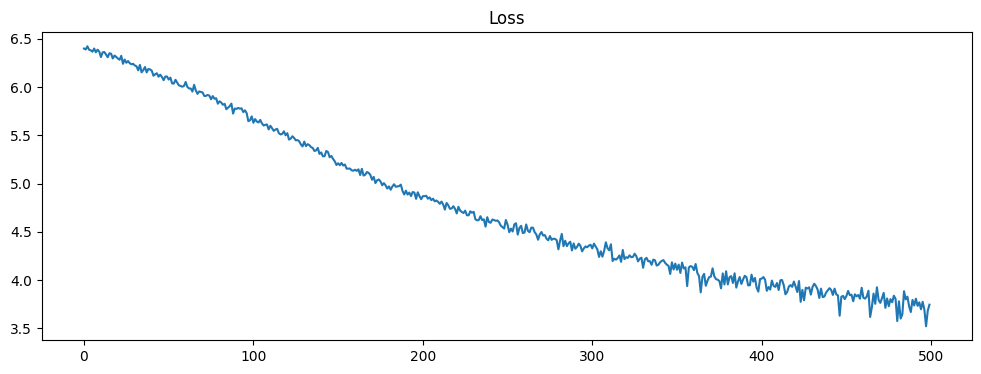

In [18]:
plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.title('Loss')
plt.show()

## Time Series Generation Post-Training

In [21]:
rng_key = jax.random.PRNGKey(128)

In [27]:
rng_key, subkey = jax.random.split(rng_key)
max_new_tokens = 480
t = int(random.randint(rng_key, shape=(), minval=0, maxval=len(X)-(3*max_new_tokens)))

# Select a random batch (t)
X_test = X.iloc[t:t+max_new_tokens]
Y_test = X.iloc[t+max_new_tokens:t+max_new_tokens+max_new_tokens].reset_index(drop=True)
#x = [encode(X_test)]
#index_seq = jnp.array(x)

#print(index_seq.shape)
#print(index_seq)


In [28]:
#rng_key, subkey = jax.random.split(rng_key)
#generated_indices = generate(variables, model.apply, index_seq, rng_key, vocab_size, 1, block_size, max_new_tokens)
#generated_indices = list(np.array(generated_indices[0]))
#Y = decode(generated_indices, X)

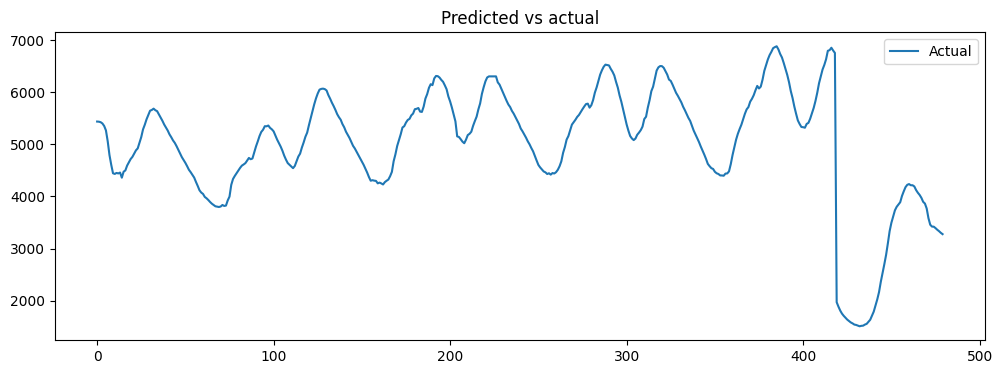

In [29]:
plt.figure(figsize=(12, 4))
#plt.plot(Y.index, Y['Power demand'], label="Predicted")
plt.plot(Y_test.index, Y_test['Power demand'], label="Actual")
plt.title('Predicted vs actual')
plt.legend()
plt.show()